## Utility to get lat/long of gruhas and nakshtras for a given date range
## Gruhas position are sourced from planet_pos_3000BCE_for_5k_years_at_7day_interval.csv.gz ( which is generated by make_planetpos.ipynb .. i think)
## Nakshatra position are naks_lat_long.tsv genrated by stel_scripts/nakshatras.inc!GetNaksLatLong function
## The JD of the above data sources while aligned around +2000 drift by about 30 days at -3000 ( an acceptable drift)

In [1]:
import math
import numpy as np
import pandas as pd
import datetime
import time
import glob
from astropy.time import Time
import re
import matplotlib.pyplot as plt

In [2]:
PPCSV = './data/planet_pos_3000BCE_for_5k_years_at_7day_interval.csv.gz'
PP_DF = pd.read_csv(PPCSV, compression="gzip").drop(['index'] , axis=1)
PP_DF.shape 

(1825005, 10)

In [3]:
PP_DF['datex'] = PP_DF["date"]
PP_DF['date'] =  [ re.sub("T.*","",x) for x in PP_DF["date"]]

In [4]:
NAKS_TSV='./data/naks_lat_long.tsv'
NAKS_DF = pd.read_csv(NAKS_TSV, sep="\t")
NAKS_DF.shape

(28, 8)

In [5]:
PP_DF.columns, NAKS_DF.columns

(Index(['planet', 'jd', 'date', 'ecl_long', 'ecl_lati', 'geo_r', 'geoc_x',
        'geoc_y', 'geoc_z', 'helio_r', 'datex'],
       dtype='object'),
 Index(['nid', 'nname', 'date', 'jd', 'long', 'lat', 'long_rate_dpc',
        'lat_rate_dpc'],
       dtype='object'))

In [6]:
pp_pvt = PP_DF.pivot_table(columns='planet', index=['jd', 'date'] , values=['ecl_long','ecl_lati']).reset_index()#.astype({ 'jd' : int})
pp_pvt.columns = [ re.sub("^ecl_|_$","", x) for x in pp_pvt.columns.to_series().str.join('_')]
pp_pvt.sample(4)

,jd,date,lati_Jupiter,lati_Mars,lati_Mercury,lati_Moon,lati_Saturn,lati_Sun,lati_Venus,long_Jupiter,long_Mars,long_Mercury,long_Moon,long_Saturn,long_Sun,long_Venus
89739,1253505.5,-1281-11-19,1.405036,-1.146192,-1.797105,1.127391,1.202887,0.0,-0.342294,169.927904,307.749813,239.267311,13.173768,234.922853,236.354431,238.307977
95510,1293902.5,-1170-06-26,-0.877515,-5.818375,-2.089951,-0.803904,2.373955,0.0,1.545959,277.873234,252.603015,73.427316,217.657609,152.631597,91.768091,121.005469
236541,2281119.5,1533-05-24,0.394260,-1.687459,2.189267,1.803493,-0.254020,0.0,-1.374643,266.167290,359.492952,81.016383,309.254969,99.372807,62.084606,41.049256
250898,2381618.5,1808-07-20,-1.325794,0.612802,-4.021086,-2.318757,2.252993,0.0,0.761310,347.544706,94.134716,132.384558,74.641005,226.242305,117.015039,113.116888


In [7]:
jdlow = pp_pvt[ ['-600-' in  x for x in pp_pvt.date] ].jd.min()
jdhi= pp_pvt[ ['-500-' in  x for x in pp_pvt.date] ].jd.max()
pp_pvt_slice  = pp_pvt[ (pp_pvt.jd >= jdlow ) &  (pp_pvt.jd <= jdhi) ].reset_index().set_index('date')
for n in range(NAKS_DF.shape[0]) :
  naks = NAKS_DF.iloc[n,:]
  pp_pvt_slice[ '_'.join(['long' , naks.nid, naks.nname]) ] = [1*naks.long - 1*(naks.jd - pp_pvt_slice.iloc[i,:].jd)*(naks.long_rate_dpc/100/365) for i in range(pp_pvt_slice.shape[0])]
pp_pvt_slice.to_csv("data/gruha_naks_lat_long_600bce_500bce.tsv", sep="\t")
pp_pvt_slice.head().T

date,-600-01-01,-600-01-08,-600-01-15,-600-01-22,-600-01-29
index,1.252260e+05,1.252270e+05,1.252280e+05,1.252290e+05,1.252300e+05
jd,1.501914e+06,1.501922e+06,1.501928e+06,1.501936e+06,1.501942e+06
lati_Jupiter,-6.881173e-01,-6.978875e-01,-7.087600e-01,-7.207820e-01,-7.340023e-01
lati_Mars,4.965908e-01,4.113648e-01,3.187405e-01,2.183335e-01,1.097723e-01
lati_Mercury,-5.606720e-01,-1.307933e+00,-1.823955e+00,-2.051750e+00,-1.919125e+00
lati_Moon,1.127057e+00,4.826115e+00,-2.589291e+00,-4.573586e+00,2.005077e+00
lati_Saturn,-1.039039e-01,-1.130282e-01,-1.223252e-01,-1.318233e-01,-1.415495e-01
lati_Sun,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
lati_Venus,1.712603e+00,2.890098e+00,4.200625e+00,5.591792e+00,6.941689e+00
long_Jupiter,2.874244e+02,2.891017e+02,2.907802e+02,2.924527e+02,2.941118e+02


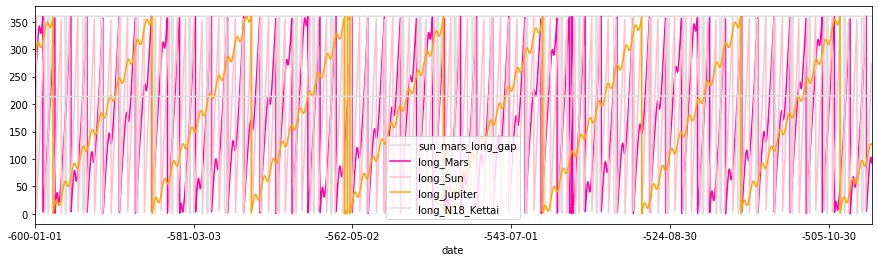

In [8]:
pp_pvt_slice['sun_mars_long_gap'] = [ x if x <10 else 360 for x in np.abs(pp_pvt_slice.long_Sun - pp_pvt_slice.long_Mars)]
ax=pp_pvt_slice [ ['sun_mars_long_gap' , 'long_Mars', 'long_Sun', 'long_Jupiter' ,'long_N18_Kettai'] ].plot(figsize=(15,4), colors=['#dddddd' , '#ff00aa' , 'pink', 'orange'], marker = '' , logy=not True)
#ax.set_xticks(pp_pvt_slice.jd);
#ax.set_xticklabels(pp_pvt_slice.index, rotation=90)

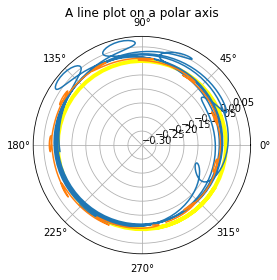

In [9]:
ax = plt.subplot(111, projection='polar')

theta = pp_pvt_slice.head(60).long_Sun *np.pi/180
r = pp_pvt_slice.head(60).lati_Sun *np.pi/180
ax.plot(theta, r, color ='yellow', linewidth=4)
# ax.set_rticks(np.arange(-.3, .1,.05))  # less radial tick

ax.set_title("A line plot on a polar axis", va='bottom')
theta = pp_pvt_slice.head(500).long_Mars *np.pi/180
r = pp_pvt_slice.head(500).lati_Mars *np.pi/180
ax.plot(theta, r)
# ax.set_rticks(np.arange(-.3, .1,.05))  # less radial ticks

theta = pp_pvt_slice.head(600).long_Jupiter *np.pi/180
r = pp_pvt_slice.head(600).lati_Jupiter *np.pi/180
ax.plot(theta, r)
ax.set_rticks(np.arange(-.3, .1,.05))  # less radial tick

plt.show()

In [10]:
PPR = { #paripadal_planets_raasi
'Mars'    :  [ 1, 'Mesa'],
'Venus'   :  [ 2, 'Rushabha'],
'Mercury' :  [ 3, 'Mithuna'],
'Saturn'  :  [10, 'Makara'],
'Jupiter' :  [12, 'Mina']
}

#PPR_Error_DF = pd.DataFrame({ p: (PP_DF[PP_DF.planet == p].ecl_long - PPR[p][0]) for p in PPR.keys() })

PPR_Error_DF = pd.DataFrame({ p: abs(PP_DF[PP_DF.planet == p].reset_index().ecl_long - (PPR[p][0]*13.33 -(13.33/2))) for p in PPR.keys() })
PPR_Error_DF['date'] = PP_DF.loc[:,'date'].unique()
PPR_Error_DF['sum'] = PPR_Error_DF.sum(axis=1)
#PPR_Error_DF=PPR_Error_DF.set_index('date')

PPR_Error_DF.shape, PP_DF.shape

((260715, 7), (1825005, 11))

In [11]:
PPR_Error_DF.iloc[PPR_Error_DF.loc[:,'sum'].idxmin(), :]

Mars          7.93955
Venus       0.0622704
Mercury       2.03392
Saturn        2.24701
Jupiter       20.8663
date       -878-05-17
sum            33.149
Name: 110740, dtype: object

In [12]:
#[ re.match("(\-?\d+)",dt)[1] for dt in PPR_Error_DF.sort_values(by='sum', ascending=1).head(100)['date']]
PPR_Error_DF['year'] = PPR_Error_DF.sort_values(by='sum', ascending=1)['date'].apply(lambda dt: (re.match("(\-?\d+)",dt))[1])

In [13]:
 PPR_Error_DF.sort_values(by='sum', ascending=1).head(100).sort_values(by='year')

,Mars,Venus,Mercury,Saturn,Jupiter,date,sum,year
98477,12.911115,9.893331,3.349789,2.010935,44.145049,-1113-05-07,72.310219,-1113
98372,4.766810,15.222069,5.695422,22.326217,18.595374,-1115-05-02,66.605893,-1115
98373,0.192449,11.432201,5.397060,21.764304,18.096992,-1115-05-09,56.883006,-1115
98374,5.097933,9.189565,1.259698,21.145419,17.472849,-1115-05-16,54.165464,-1115
98376,14.741082,10.328106,17.612574,19.759006,15.880687,-1115-05-30,78.321456,-1115
...,...,...,...,...,...,...,...,...
187490,22.957526,10.406871,6.960461,7.633680,2.197784,593-04-24,50.156322,593
187491,27.963249,1.909270,21.313066,7.296258,2.101850,593-05-01,60.583692,593
199854,15.463120,7.922644,22.018983,13.137966,1.097664,830-04-10,59.640377,830
199856,25.619892,25.147338,7.753665,13.025002,1.587123,830-04-24,73.133020,830
